In [ ]:
import tensorflow_datasets as tfds
import keras
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding
from transformers import BertTokenizer
from tensorflow.keras.layers import LSTM, Dense, Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay, classification_report

In [ ]:
!kaggle datasets download -d lakshmi25npathi/imdb-dataset-of-50k-movie-reviews
!unzip imdb-dataset-of-50k-movie-reviews.zip
!rm imdb-dataset-of-50k-movie-reviews.zip

Dataset URL: https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews
License(s): other
 66% 17.0M/25.7M [00:00<00:00, 65.0MB/s]
100% 25.7M/25.7M [00:00<00:00, 71.9MB/s]
Archive:  imdb-dataset-of-50k-movie-reviews.zip
  inflating: IMDB Dataset.csv        


In [ ]:
dataset =  pd.read_csv("IMDB Dataset.csv")

In [ ]:
dataset.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
dataset['sentiment'] = dataset['sentiment'].apply(lambda x: 1 if x == 'positive' else 0).values

In [ ]:
dataset.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [ ]:
texts = dataset['review'].values
labels = dataset['sentiment'].values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(texts, labels,
                                                    test_size=0.2, random_state=42)

# Enbeding

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased',)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
tokenized_texts_test = [tokenizer.encode(text, add_special_tokens=True, truncation= True) for text in X_test]
tokenized_texts_train = [tokenizer.encode(text, add_special_tokens=True, truncation= True) for text in X_train]


In [ ]:
# Passo 3: Aplicar padding às sequências
max_len = 512  # Defina o tamanho máximo da sequência
padded_texts_test = pad_sequences(tokenized_texts_test, maxlen=max_len, padding='post')
padded_texts_train = pad_sequences(tokenized_texts_train, maxlen=max_len, padding='post')

# Passo 4: Criar o modelo LSTM
vocab_size = tokenizer.vocab_size  # Tamanho do vocabulário do BERT
embedding_dim = 768  # Pode ser ajustado conforme necessário

# LSTM

In [ ]:
#  LSTM
model = keras.Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len),
    LSTM(32, return_sequences=False, input_shape=(32, 512)),
    keras.layers.Dropout(0.3),
    Dense(32, activation='relu'),
    keras.layers.Dropout(0.3),
    Dense(1, activation='sigmoid')
])


In [ ]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True, True]


In [ ]:
# Compilar o modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(padded_texts_train, y_train, epochs=5, batch_size=32 , validation_split= 0.2)

Epoch 1/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 40s 34ms/step - accuracy: 0.5014 - loss: 0.6946 - val_accuracy: 0.5189 - val_loss: 0.6884
Epoch 2/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 40s 34ms/step - accuracy: 0.5399 - loss: 0.6725 - val_accuracy: 0.5230 - val_loss: 0.6918
Epoch 3/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 43s 36ms/step - accuracy: 0.5602 - loss: 0.6277 - val_accuracy: 0.5209 - val_loss: 0.7341
Epoch 4/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 43s 39ms/step - accuracy: 0.7521 - loss: 0.4785 - val_accuracy: 0.8526 - val_loss: 0.3718
Epoch 5/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 35s 32ms/step - accuracy: 0.9192 - loss: 0.2267 - val_accuracy: 0.8593 - val_loss: 0.3787


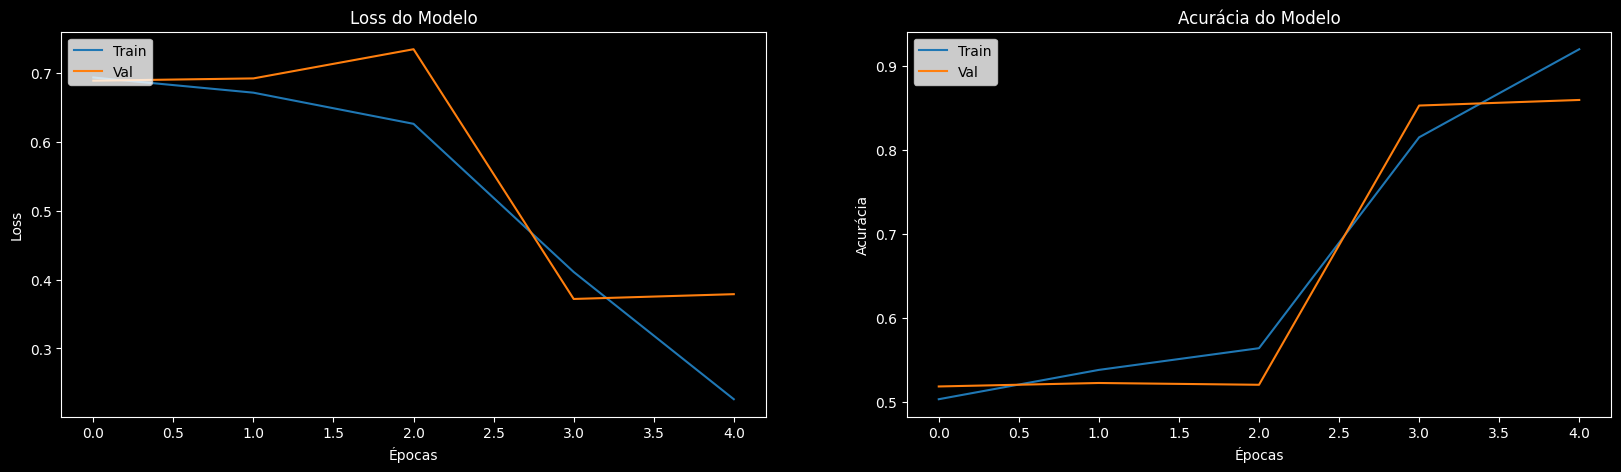

In [ ]:
plt.figure(figsize=(20, 5))

# Primeiro gráfico (Loss)
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss do Modelo', color='white')  # Cor do título
plt.ylabel('Loss', color='white')           # Cor do label do eixo Y
plt.xlabel('Épocas', color='white')         # Cor do label do eixo X
plt.legend(['Train', 'Val'], loc='upper left')

# Mudar cor dos eixos para branco
ax = plt.gca()
ax.set_facecolor('black')
ax.spines['bottom'].set_color('white')
ax.spines['top'].set_color('white')
ax.spines['right'].set_color('white')
ax.spines['left'].set_color('white')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')

# Segundo gráfico (Accuracy)
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Acurácia do Modelo', color='white')
plt.ylabel('Acurácia', color='white')
plt.xlabel('Épocas', color='white')
plt.legend(['Train', 'Val'], loc='upper left')

# Mudar cor dos eixos para branco
ax = plt.gca()
ax.set_facecolor('black')
ax.spines['bottom'].set_color('white')
ax.spines['top'].set_color('white')
ax.spines['right'].set_color('white')
ax.spines['left'].set_color('white')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')

# Alterar a cor do fundo da figura principal
plt.gcf().set_facecolor('black')

plt.show()


In [ ]:
#teste accuracya
loss, accuracy = model.evaluate(padded_texts_test, y_test)
print(f'Acurácia no conjunto de teste: {accuracy * 100:.2f}%')

313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.8541 - loss: 0.3863
Acurácia no conjunto de teste: 85.41%


In [ ]:
# Fazer previsões nos dados de teste
y_pred = model.predict(padded_texts_test)
y_pred = (y_pred >= 0.5).astype(int)



313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step


In [ ]:
cm = confusion_matrix(y_test, y_pred)

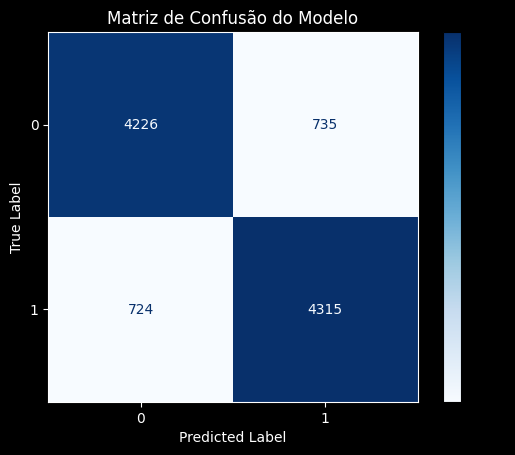

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Supondo que você já tenha a matriz de confusão 'cm' e os rótulos 'label_names'
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])

# Criar a visualização da matriz de confusão
fig, ax = plt.subplots()
disp_test.plot(cmap=plt.cm.Blues, ax=ax)

# Alterar o fundo do gráfico para preto
ax.set_facecolor('black')

# Alterar a cor das bordas do gráfico (spines) para branco
ax.spines['bottom'].set_color('white')
ax.spines['top'].set_color('white')
ax.spines['right'].set_color('white')
ax.spines['left'].set_color('white')

# Alterar as cores dos rótulos dos eixos (labels)
ax.set_xlabel('Predicted Label', color='white')
ax.set_ylabel('True Label', color='white')

# Alterar a cor dos ticks e dos tick labels para branco
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')

# Alterar o título para branco
plt.title('Matriz de Confusão do Modelo', color='white')

# Alterar o fundo da figura principal para preto
plt.gcf().set_facecolor('black')

plt.show()


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.85      0.85      4961
           1       0.85      0.86      0.86      5039

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



In [ ]:
# Obter as previsões do modelo para o conjunto de teste
y_pred_prob = model.predict(padded_texts_test)
y_pred = (y_pred_prob >= 0.5).astype(int).flatten()

# Encontrar os índices onde as previsões estão incorretas
incorrect_indices = np.where(y_pred != y_test)[0]

# Criar uma lista com os exemplos incorretos
incorrect_examples = []
for i in incorrect_indices:
  incorrect_examples.append({
      'review': X_test[i],
      'true_label': y_test[i],
      'predicted_label': y_pred[i],
      'predicted_probability': y_pred_prob[i][0]
  })

# Imprimir os exemplos incorretos
for example in incorrect_examples:
  print(f"Review:")
  print(example['review'])
  print(f"True Label: {example['true_label']}")
  print(f"Predicted Label: {example['predicted_label']}")
  print(f"Predicted Probability: {example['predicted_probability']:.4f}")
  print("-" * 50)


A saída de streaming foi truncada nas últimas 5000 linhas.
Predicted Probability: 0.5921
--------------------------------------------------
Review:
Quite liked Flesh and looking forward to Heat but couldn't help but feel Morrissey grossly exploited most of the "performers" featured here. Stumbling around naked in a narcotic stupor seems to be all Dallesandro was capable of in this feature--a huge and heartbreaking contrast from Flesh. His semi-erection in a few scenes is the only indication that he might be acting; mostly it looks like something he did to buy drugs. Woodlawn is a revelation all right--she is the embodiment of the Lower East Side. But hers is a one woman show--she rarely engages the other performers though, it has to be said, her sex scene with a beer bottle definitely leaves Halle Berry in the shade when it comes to cinematic displays of raw passion. When she pounces on a young, would-be lover it is with the ferocity of a vampire. Two of the female performers, Andrea a